# Registering multiple frames to first frame

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj

## Implement EM-based OT registration

In [3]:
def _compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)
    
    # Compute transport plan
    return ot.emd(p_1, p_2, M, log=True)
    

def _ot_reg(pts_1, pts_2, wts_1, wts_2, p_mtx):
    """Compute weighted polynomial regression using OT plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(p_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = p_mtx[idx_1, idx_2]

    # Use sklearn to minimize cost function
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=True))
    ])
    model.fit(x, y, linear__sample_weight=smp_wt)

   
    return model


def ot_reg_poly(pts_s, pts_t, wts_s, wts_t, n_iter):
    """EM-based OT registration method with polynomial model."""
    
    model = [None] * n_iter
    p_mtx = [None] * n_iter
    ot_log = [None] * n_iter
    
    pts = [pts_s] + [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT between current points and target points
        p_mtx[i], ot_log[i] = _compute_ot(pts[i], pts_t, wts_s, wts_t)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  _ot_reg(pts_s, pts_t, wts_s, wts_t, p_mtx[i])
       
        # Update points 
        pts[i + 1] = model[i].predict(pts_s)
       
    debug = {
        'model': model,
        'pts': pts,
        'p_mtx': p_mtx,
        'ot_log': ot_log,
    }
    
    return model[-1], debug

## Load data

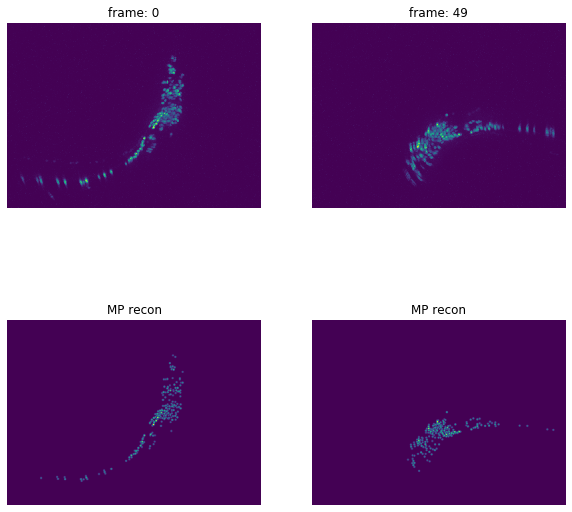

In [4]:
# Frames to load
t_start = 0
n_frames = 50
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img = [reader.get_frame(t) for t in t_vals]
    img_shape = img[0].shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in t_vals]
wts = [mp_data['weights'][t, :, 0] for t in t_vals]

# Reconstruct images from MPs
rec = [imagerep.reconstruct_image(pts[i], [cov], wts[i], img_shape) for i in range(n_frames)]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img[k1])
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img[k2])
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec[k1])
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec[k2])
plt.title('MP recon')
plt.axis('off');

## Register all frames to first frame directly

In [5]:
models = [None] * (n_frames - 1)
debug = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    models[t], debug[t] = ot_reg_poly(pts[0], pts[t + 1], wts[0], wts[t + 1], 50)

## Inspect mappings by comparing reconstructions to real frames

### Reconstruct all frames by applying learned mapping to first frame

In [6]:
t_rec = [rec[0]] + [None] * (n_frames - 1)

for t in range(1, n_frames):
    
    t_rec_pts = models[t - 1].predict(pts[0])
    t_rec[t] = imagerep.reconstruct_image_2(t_rec_pts, wts[0], cov, img_shape)

### Plot single frame next to reconstruction

(-0.5, 889.5, -0.5, 649.5)

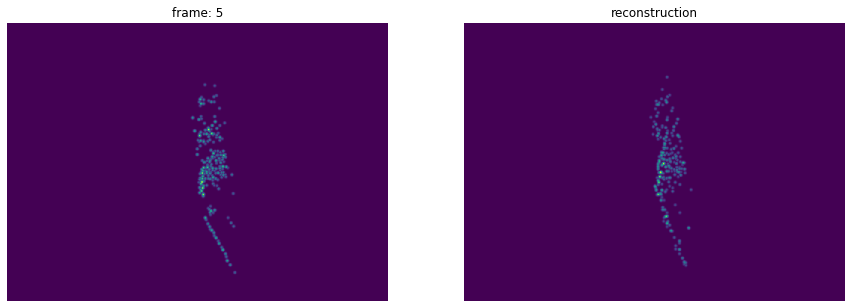

In [7]:
t = 5

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(rec[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj(t_rec[t])
plt.title('reconstruction')
plt.axis('off')

### Create video of all frame reconstructions

In [8]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15))

ax_1.set_title('frame')
ax_2.set_title('reconstruction')

ax_1.axis('off')
ax_2.axis('off')

def animate(t):
    plot_maxproj(rec[t], ax=ax_1, animated=True)
    plot_maxproj(t_rec[t], ax=ax_2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)

ani.save('ot_reg_demo.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())